In [1]:
import pandas as pd
from torch import Tensor
import warnings
warnings.filterwarnings("ignore")
import argparse
import sys
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset 
# Extract a subset from the original dataset based on the specified index list
from torch.cuda.amp import autocast, GradScaler
# Dynamically adjust losses and gradients
from sklearn.metrics import roc_auc_score
import dataset
import scanpy as sc
from utils import make_directory, make_logger, get_run_info
from utils import set_seed
from sklearn.metrics import adjusted_rand_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import warnings
import shutil #File operation tool module
import time
import numpy as np
import logging
from typing import Literal, Optional, Tuple, List, Any
from argparse import Namespace
from subprocess import Popen, PIPE
import random

### Data Preprocess

In [5]:
adata = sc.read_h5ad("/home/daozhang/ChIP-SANGO/data/Lung/LungA_LungB.h5ad")
print(np.unique(adata.obs["Batch"]))

['LungA' 'LungB']


In [6]:
adata.obs

,cell,tissue,tissue.replicate,cluster,subset_cluster,tsne_1,tsne_2,subset_tsne1,subset_tsne2,id,cell_label,Batch,CellType,batch,n_genes
0,AGCGATAGAACGAATTCGCCTCCGACGGCAGGACGT,Lung,Lung2_62216,10,1,16.258044,17.056744,-14.448729,-3.100071,clusters_10.cluster_1,Hematopoietic progenitors,LungB,Hematopoietic progenitors,1,2121
1,AGCGATAGACTATTCATTATCGAGATGAAGGCGAAG,Lung,Lung1_62216,10,1,14.965467,17.957911,-12.933741,-5.142383,clusters_10.cluster_1,Hematopoietic progenitors,LungA,Hematopoietic progenitors,1,1100
2,AGCGATAGCATTATTATTGTAGGCAATTGGCTCTGA,Lung,Lung1_62216,10,1,15.144736,10.113435,2.118139,-18.911213,clusters_10.cluster_1,Hematopoietic progenitors,LungA,Hematopoietic progenitors,1,1073
3,AGCGATAGCGTCGAGCGCTGATACTCAATATAGCCT,Lung,Lung2_62216,10,1,8.088171,15.092709,17.862621,7.847612,clusters_10.cluster_1,Hematopoietic progenitors,LungB,Hematopoietic progenitors,1,1909
4,AGCGATAGCTAAGCCTTGGTAGGCAATTATAGAGGC,Lung,Lung1_62216,10,1,7.740658,13.815694,23.602337,2.552785,clusters_10.cluster_1,Hematopoietic progenitors,LungA,Hematopoietic progenitors,1,1234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,ATTACTCGGATCTTCGCAAGGCGCTAGGAGGCGAAG,Lung,Lung1_62216,9,1,4.023449,-1.582937,-4.272581,-24.489281,clusters_9.cluster_1,Unknown,LungA,Unknown,1,801
9992,TAATGCGCCGTTACCGCTACTGAGCGACATAGAGGC,Lung,Lung2_62216,9,1,0.263797,5.748874,-27.478185,6.025659,clusters_9.cluster_1,Unknown,LungB,Unknown,1,2243
9993,TCCGCGAAAAGTAGCTCAATCGAGATGATATAGCCT,Lung,Lung1_62216,9,2,-2.359496,-1.703133,16.051605,1.935439,clusters_9.cluster_2,Endothelial II cells,LungA,Endothelial II cells,1,901
9994,CGGCTATGCAGCTAGCGGTCGTCCTTCGTATAGCCT,Lung,Lung2_62216,9,2,-0.452609,-4.472619,13.111107,0.066414,clusters_9.cluster_2,Endothelial II cells,LungB,Endothelial II cells,1,894


In [7]:
adata.var

,chrom,chromStart,chromEnd,chr,start,end,n_cells
5,chr1,3109571,3111047,chr1,3109571,3111047,135
92,chr1,3660494,3662750,chr1,3660494,3662750,249
140,chr1,4481787,4483554,chr1,4481787,4483554,162
142,chr1,4486198,4487697,chr1,4486198,4487697,167
150,chr1,4561274,4562504,chr1,4561274,4562504,137
...,...,...,...,...,...,...,...
436179,chrX,166418652,166420035,chrX,166418652,166420035,477
436187,chrY,345823,347369,chrY,345823,347369,937
436197,chrY,581272,582790,chrY,581272,582790,798
436201,chrY,621772,623366,chrY,621772,623366,1016


In [5]:
def make_anndata(adata, chrom, start, end, path):
    adata.var['chr'] = chrom
    adata.var['start'] = start
    adata.var['end'] = end

    # basic stats
    sc.pp.filter_cells(adata, min_genes=0)
    sc.pp.filter_genes(adata, min_cells=0)

    # a peak need to be accessible in 1% cells
    thres = int(adata.shape[0]*0.01)
    adata = adata[:, adata.var['n_cells']>thres]

    chrs = ['chr'+str(i) for i in range(1,23)] + ['chrX', 'chrY']
    adata = adata[:, adata.var['chr'].isin(chrs)]
    
    print(adata)
    adata.write(path)
    return adata

In [6]:
adata_reference = adata[adata.obs["Batch"] == "LungB"]
adata_query = adata[adata.obs["Batch"] == "LungA"]

concat_adata = sc.AnnData.concatenate(adata_reference, adata_query)
print(concat_adata)

concat_adata = make_anndata(
    concat_adata,
    concat_adata.var["chrom"],
    concat_adata.var["chromStart"],
    concat_adata.var["chromEnd"],
    "/home/daozhang/ChIP-SANGO/preprocessed_data/LungB_LungA.h5ad",
)

AnnData object with n_obs × n_vars = 9996 × 72608
    obs: 'cell', 'tissue', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'Batch', 'CellType', 'batch', 'n_genes'
    var: 'chrom', 'chromStart', 'chromEnd', 'chr', 'start', 'end', 'n_cells'
View of AnnData object with n_obs × n_vars = 9996 × 72608
    obs: 'cell', 'tissue', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'Batch', 'CellType', 'batch', 'n_genes'
    var: 'chrom', 'chromStart', 'chromEnd', 'chr', 'start', 'end', 'n_cells'


In [7]:
!python train.py -i /home/daozhang/ChIP-SANGO/preprocessed_data/LungB_LungA.h5ad \
            -g mm9 \
            -o /home/daozhang/ChIP-SANGO/output/LungB_LungA \
            --tissue Lung
            # --bw_list H3k4me1_mm9.bigWig H3k4me3_mm9.bigWig \
            # --epifeature_dim 2

INFO(20250116 20:12:59) [train.py:116]:
##time: Thu Jan 16 20:12:59 2025
##cwd: /home/daozhang/ChIP-SANGO/ChIP-SANGO/CACNN
##cmd: train.py -i /home/daozhang/ChIP-SANGO/preprocessed_data/LungB_LungA.h5ad -g mm9 -o /home/daozhang/ChIP-SANGO/output/LungB_LungA --tissue Lung
##args: Namespace(data='/home/daozhang/ChIP-SANGO/preprocessed_data/LungB_LungA.h5ad', z=64, g='mm9', lr=0.01, batch_size=128, num_workers=12, seq_len=1344, outdir='/home/daozhang/ChIP-SANGO/output/LungB_LungA', w=False, seed=2020, max_epoch=300, device=0, use_reg_cell=False, alpha=0.0, epifeature_dim=3, root_path='/home/daozhang/ChIP-SANGO/data/', tissue='Lung', bw_list=['H3k4me1_mm9.bigWig', 'H3k27ac_mm9.bigWig', 'H3k4me3_mm9.bigWig'])
Calculating AP: 100%|██████████████████████| 2000/2000 [00:04<00:00, 472.53it/s]
Epoch 100/300: 100%|█| 567/567 [00:21<00:00, 26.57it/s, loss/lr=0.1101/8.100e-03
Calculating AP: 100%|██████████████████████| 2000/2000 [00:04<00:00, 475.86it/s]
Epoch 101/300: 100%|█| 567/567 [00:21<00:00

In [8]:
test = sc.read("/home/daozhang/ChIP-SANGO/output/LungB_LungA/CACNN_output.h5ad")

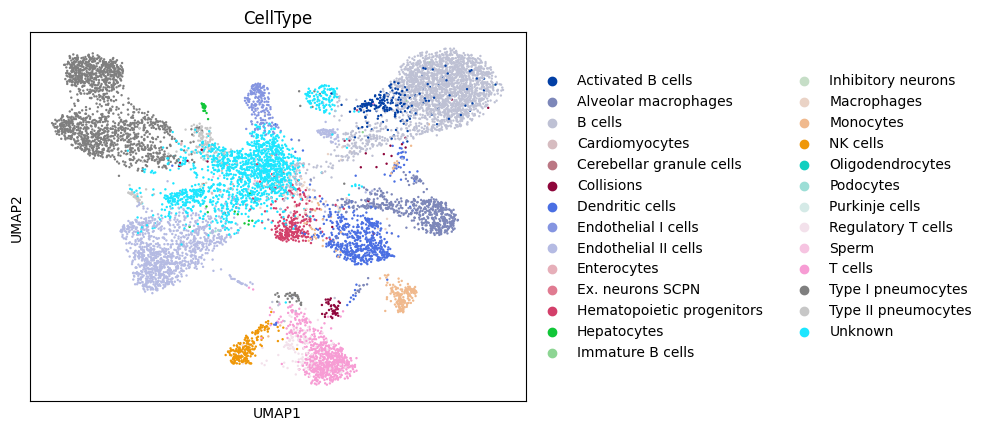

In [9]:
sc.pl.umap(test, color=['CellType'])

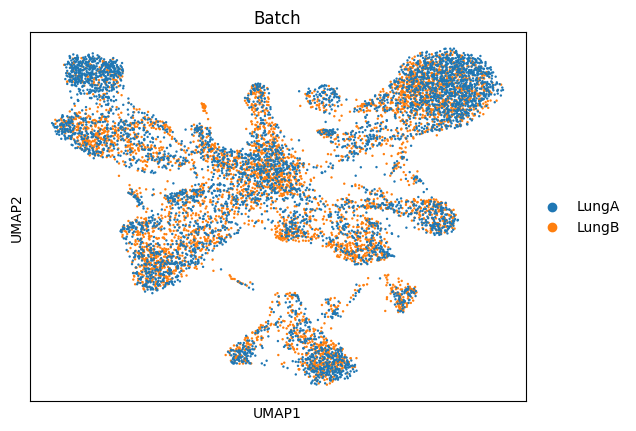

In [10]:
sc.pl.umap(test, color=['Batch'])